# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services_Part2


In [1]:
# import libraries
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.externals import joblib

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer
from sklearn.cluster import KMeans

# to get rid of jupyter notebook warnings
import warnings
warnings.simplefilter('ignore')

# magic word for producing visualizations in notebook
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


## Part 2: Feature Transformation


#### Azdias Dataset

In [2]:
# load in the clean azdias data
azdias_df = pd.read_csv('./data/azdias_cleaned.csv')

In [3]:
# view azdias dataset
azdias_df.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST
0,910220,9.0,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,910225,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2,910226,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0,0,0,0,0,1,0,0,0,0
3,910241,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,910244,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# create pipeline to fill in NaNs and Scale features for azdias dataset
pipeline = Pipeline([
    ("imputer", IterativeImputer(random_state=42)), 
    ("scaler", StandardScaler())], verbose=True)

In [5]:
# fit_transform pipeline to azdias dataset
# this takes quite some time as I am not using a simple imputer to fill in NA
azdias_trans = pipeline.fit_transform(azdias_df)

[Pipeline] .......... (step 1 of 2) Processing imputer, total=762.2min
[Pipeline] ............ (step 2 of 2) Processing scaler, total=  10.3s


In [6]:
# save intermediate pickle file
# I did this because of computation time so I can easily resume notebook as necessary
joblib.dump(azdias_trans, "./model/azdias_transform.pkl")

['./model/azdias_transform.pkl']

In [7]:
# implement PCA to reduce number of features
# run pca using all the features (columns) which is currently 389
pca = PCA(random_state=42)
azdias_pca = pca.fit_transform(azdias_trans)

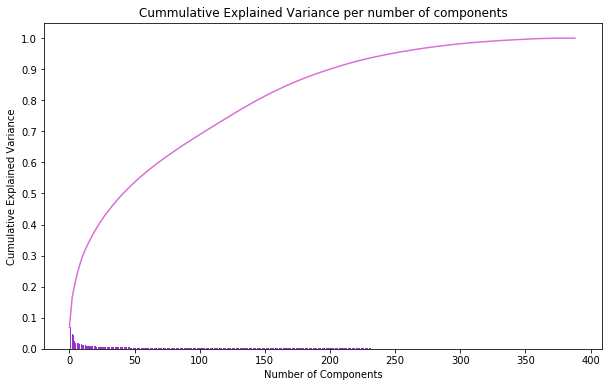

In [8]:
# plot scree plot to determine optimal number of features to use
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color="orchid")
plt.bar(np.arange(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, color="darkorchid")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Cummulative Explained Variance per number of components")
# plt.grid(True)
# plt.grid(axis="x")
plt.yticks(np.arange(0, 1.1, 0.1))
plt.show()

In [9]:
# re-implement pca with 200 components which explains about 90% variance
pca_200 = PCA(n_components=200, random_state=42)
azdias_pca200 = pca_200.fit_transform(azdias_trans)

In [10]:
# save intermediate pickle file
joblib.dump(azdias_pca200, "./model/azdias_pca.pkl")

['./model/azdias_pca.pkl']

In [11]:
# create dataframe of explained variance, explained variance per feature for the 200 Dimensions from above
feat_weight_df = pd.DataFrame((np.round(pca_200.components_, 4)), columns=azdias_df.columns)

# rename index
index = ["Dimension-{}".format(x) for x in np.arange(1, feat_weight_df.shape[0] + 1)]
feat_weight_df.index = index

# add EXPLAINED_VARIANCE column and reorder to first column
feat_weight_df["EXPLAINED_VARIANCE"] = np.round(pca_200.explained_variance_ratio_, 4)
new_col = ["EXPLAINED_VARIANCE"] + list(azdias_df.columns)
feat_weight_df = feat_weight_df[new_col]
feat_weight_df.head()

,EXPLAINED_VARIANCE,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST
Dimension-1,0.0696,-0.0291,0.0562,0.0086,0.0283,0.0830,0.0182,-0.0186,-0.0582,0.0819,...,-0.0070,-0.0050,0.0016,0.0008,-0.0039,0.0152,-0.0017,-0.0181,-0.0104,-0.0046
Dimension-2,0.0465,0.0763,0.0038,-0.0370,-0.0337,0.0240,0.0287,-0.0168,-0.0192,0.0233,...,0.0083,-0.0017,-0.0036,-0.0019,-0.0032,0.0088,-0.0054,-0.0122,-0.0044,0.0035
Dimension-3,0.0455,-0.0351,-0.0443,-0.1860,-0.1683,0.0166,0.0108,-0.0673,-0.0409,0.0193,...,0.0023,-0.0022,-0.0066,0.0011,-0.0038,0.0423,-0.0215,-0.0094,0.0073,0.0044
Dimension-4,0.0238,-0.1265,-0.0625,0.0528,0.0429,0.0037,0.0147,0.0461,0.0910,0.0058,...,0.0090,0.0088,0.0104,0.0042,0.0053,-0.0554,0.0146,0.0273,0.0310,0.0076
Dimension-5,0.0199,0.0490,-0.1113,0.0592,0.0141,-0.0212,-0.0071,0.0659,0.1555,-0.0235,...,0.0285,0.0135,0.0174,0.0050,0.0091,-0.0900,0.0217,0.0445,0.0315,0.0096


In [12]:
# plot feature weight per dimension
def plot_feat_weight(dim, num=60):
    """
    INPUT:
    dim - the index of the dimension to be plotted like "Dimension-1" (string)
    num = top n and bottom n to be plotted. Default is 60 (integer)
    
    OUTPUT:
    none 
    
    Description:
    plots the top and bottom n columns sorted in descending order
    """
    
    dimension = feat_weight_df.loc[dim, "LNR":].reset_index().sort_values(by=dim, ascending=False)    
    dimension_top = dimension[1:num+1]
    dimension_bottom = dimension[-num:]
    
    plt.figure(figsize=(20, 10))
    plt.subplot(211)
    sns.barplot(dimension_top["index"], dimension_top[dim])
    plt.ylabel("Feature Weights")
    plt.xlabel("Features")
    plt.xticks(rotation=90)
    
    plt.subplot(212)
    sns.barplot(dimension_bottom["index"], dimension_bottom[dim])
    plt.ylabel("Feature Weights")
    plt.xlabel("Features")
    plt.xticks(rotation=90)
    plt.subplots_adjust(bottom=0.8)
    plt.suptitle("{} : {} variance explained for top {} columns and bottom {} columns".
              format(dim, np.round(feat_weight_df.loc[dim, "EXPLAINED_VARIANCE"]*100, 2), num, num), fontsize=18)
    plt.tight_layout()    

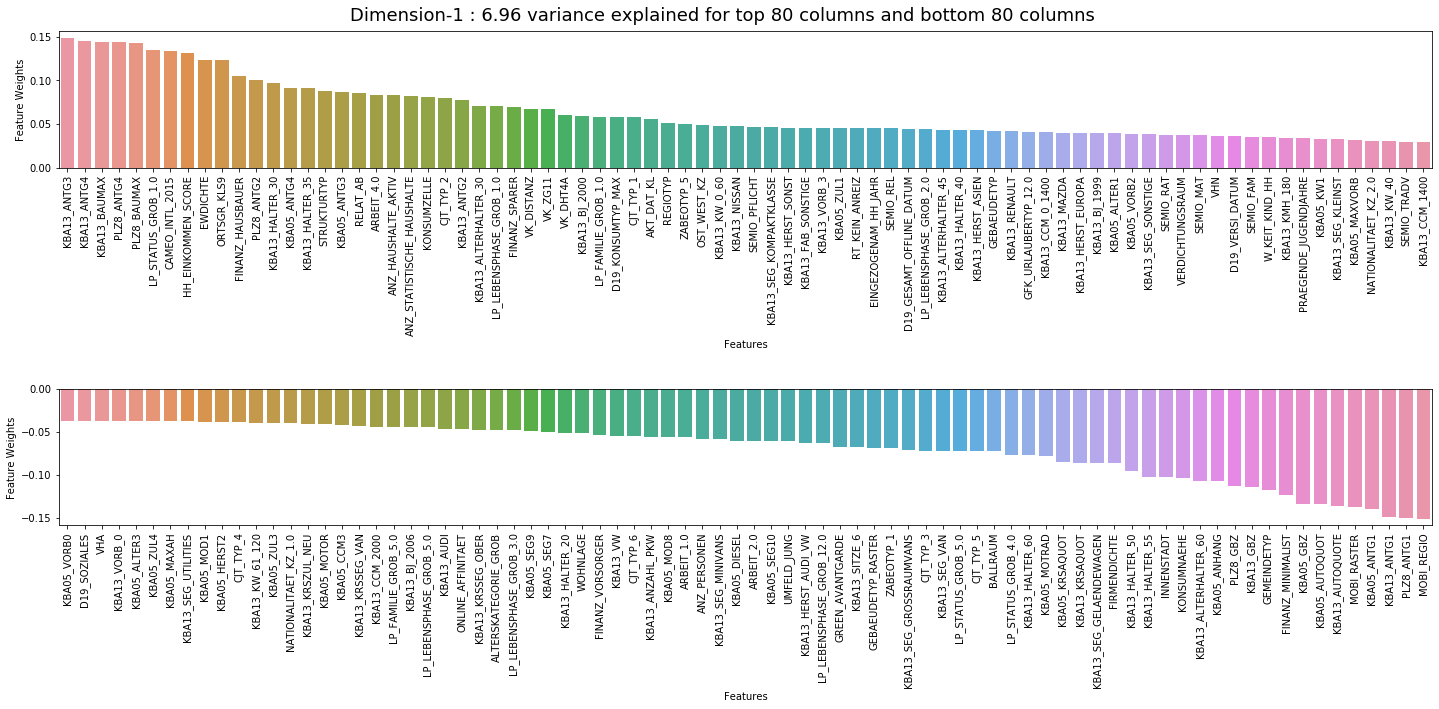

In [13]:
# plot dimension one
plot_feat_weight("Dimension-1", 80)

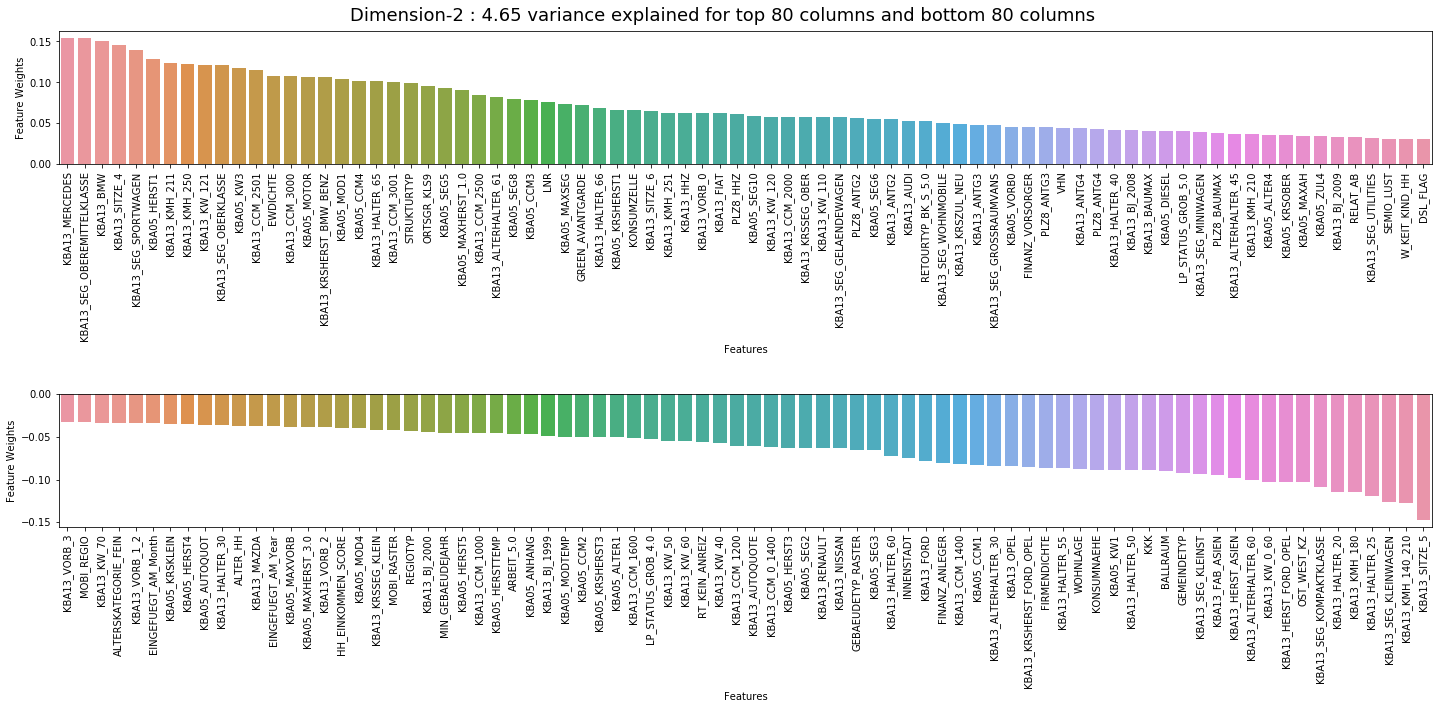

In [14]:
# plot dimension two
plot_feat_weight("Dimension-2", 80)

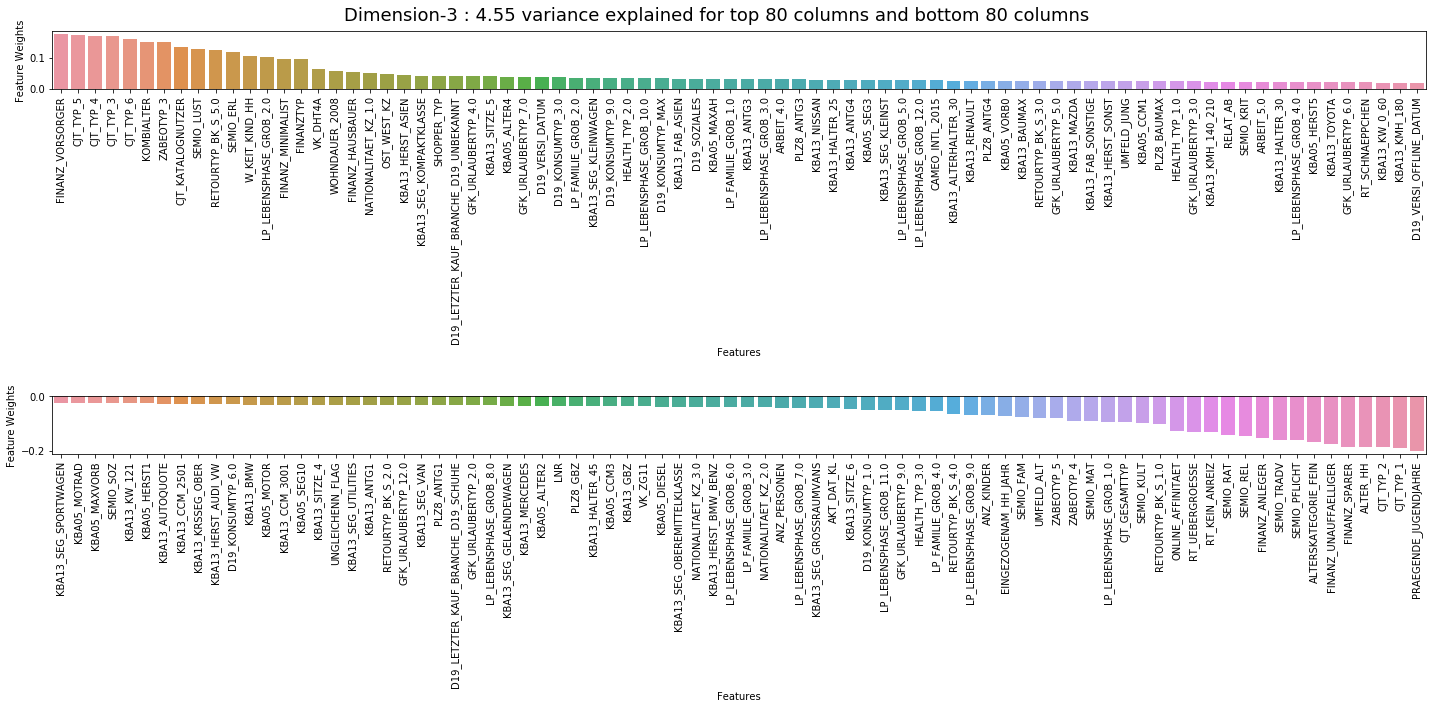

In [15]:
# plot dimension three
plot_feat_weight("Dimension-3", 80)

#### Customer Dataset

In [16]:
# load in the clean customer data
customer_df = pd.read_csv('./data/customer_cleaned.csv')

In [17]:
# view customer dataset
customer_df.head()

,LNR,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,D19_LETZTER_KAUF_BRANCHE_D19_SONSTIGE,D19_LETZTER_KAUF_BRANCHE_D19_TECHNIK,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_MOBILE,D19_LETZTER_KAUF_BRANCHE_D19_TELKO_REST,D19_LETZTER_KAUF_BRANCHE_D19_TIERARTIKEL,D19_LETZTER_KAUF_BRANCHE_D19_UNBEKANNT,D19_LETZTER_KAUF_BRANCHE_D19_VERSAND_REST,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST
0,9626,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,143872,1.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,0,0,1,0,0,0,0
2,143873,1.0,8.0,8.0,0.0,NaN,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,143874,1.0,20.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,143888,1.0,11.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# separate out 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'
# drop 'CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'
customer_extra = customer_df[["CUSTOMER_GROUP", "ONLINE_PURCHASE", "PRODUCT_GROUP"]]
customer_df = customer_df.drop(["CUSTOMER_GROUP", "ONLINE_PURCHASE", "PRODUCT_GROUP"], axis=1)

In [19]:
# transform pipeline on customer_data
customer_trans = pipeline.transform(customer_df)

In [20]:
# transform with pca on customer data
customer_pca200 = pca_200.transform(customer_trans)


## Part 3: Clustering

In [21]:
# randomly sample from the azdias dataset to improve computational speed during kmeans computation
# we are using one third of the original data
np.random.seed(42)
index = np.random.choice(azdias_pca200.shape[0], azdias_pca200.shape[0] // 3, replace=False) 
azdias_samp = azdias_pca200[index]

In [22]:
# implement KMeans
def kmeans_model(df, num_cluster):
    """
    INPUT:
    df - pandas dataframe to implement kmeans on (dataframe)
    num_cluster - number of clusters (integer)
    
    OUTPUT:
    score - cluster score (float)
    
    Description:
    - initializes kmeans and fits df
    - computes the cluster score
    """
    
    kmeans = KMeans(n_clusters=num_cluster, random_state=42, n_jobs=-1)
    model = kmeans.fit(df)
    return np.abs(model.score(df))

In [24]:
# run kmeans for num_clusters between 1 and 20, both inclusive
scores = []
for num in range(1, 21):
    score = kmeans_model(azdias_samp, num)
    scores.append(score)
    print("Done with number of clusters = {} with score = {}".format(num, score))

Done with number of clusters = 1 with score = 87271732.25807004
Done with number of clusters = 2 with score = 82279104.74241115
Done with number of clusters = 3 with score = 80242390.8430247
Done with number of clusters = 4 with score = 78605663.95736815
Done with number of clusters = 5 with score = 77333736.10046925
Done with number of clusters = 6 with score = 76363857.94078831
Done with number of clusters = 7 with score = 75647268.33639875
Done with number of clusters = 8 with score = 74976580.59675442
Done with number of clusters = 9 with score = 74456184.7099419
Done with number of clusters = 10 with score = 74021622.68260482
Done with number of clusters = 11 with score = 73638045.88094856
Done with number of clusters = 12 with score = 73270871.17185685
Done with number of clusters = 13 with score = 72959608.09981911
Done with number of clusters = 14 with score = 72636117.44918138
Done with number of clusters = 15 with score = 72364081.66448255
Done with number of clusters = 16 wi

Text(0.5, 1.0, 'SSE vs Number of Clusters')

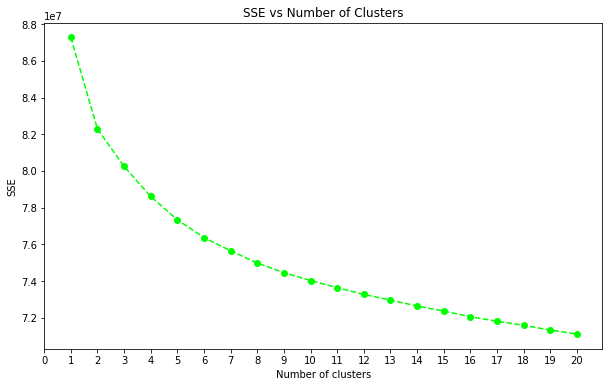

In [25]:
# plots cluster score
plt.figure(figsize=(10, 6))
ind = range(1, 21)
plt.plot(ind, scores, linestyle="--", marker="o", color="lime")
plt.xticks(np.arange(0, 21))
# plt.grid(True)
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.title("SSE vs Number of Clusters")

In [26]:
# refit azdias_df with num of clusters = 12 and predict
kmeans = KMeans(n_clusters=12, random_state=42, n_jobs=-1)
model_12 = kmeans.fit(azdias_pca200)
labels_azdias = model_12.predict(azdias_pca200)

In [27]:
# predict with model_12 on customer_df
labels_customer = model_12.predict(customer_pca200)

In [28]:
# make labels_azdias into a pandas dataframe with columns: 
# Label, Sum, Mean and originating_dataset (general for general population (azdias) data)
labels_azd_df = pd.DataFrame(labels_azdias, columns=["Label"])
labels_azd_df["Sum"] = 1
labels_azd_df = labels_azd_df.groupby(by="Label").count().reset_index()
labels_azd_df["Mean"] = labels_azd_df["Sum"] / len(labels_azdias)
labels_azd_df["Dataset"] = "general"
labels_azd_df

,Label,Sum,Mean,Dataset
0,0,72905,0.097299,general
1,1,78769,0.105125,general
2,2,75052,0.100164,general
3,3,32995,0.044035,general
4,4,35839,0.047831,general
5,5,70665,0.094309,general
6,6,85377,0.113944,general
7,7,70257,0.093765,general
8,8,46821,0.062487,general
9,9,47855,0.063867,general


In [29]:
# make labels_customer into a pandas dataframe with columns: 
# Label, Sum, Mean and originating_dataset (customer for customer data)
labels_cust_df = pd.DataFrame(labels_customer, columns=["Label"])
labels_cust_df["Sum"] = 1
labels_cust_df = labels_cust_df.groupby(by="Label").count().reset_index()
labels_cust_df["Mean"] = labels_cust_df["Sum"] / len(labels_customer)
labels_cust_df["Dataset"] = "customer"
labels_cust_df

,Label,Sum,Mean,Dataset
0,0,9744,0.071333,customer
1,1,57366,0.419959,customer
2,2,893,0.006537,customer
3,3,433,0.003170,customer
4,4,3193,0.023375,customer
5,5,936,0.006852,customer
6,6,10268,0.075169,customer
7,7,10811,0.079144,customer
8,8,3466,0.025374,customer
9,9,13212,0.096721,customer


In [30]:
# concat both labels_azd_df and labels_cust_df
labels_concat = pd.concat([labels_azd_df, labels_cust_df], ignore_index=True)
labels_concat.head()

,Label,Sum,Mean,Dataset
0,0,72905,0.097299,general
1,1,78769,0.105125,general
2,2,75052,0.100164,general
3,3,32995,0.044035,general
4,4,35839,0.047831,general


Text(0.5, 1.0, 'Percentage Distribution per Cluster')

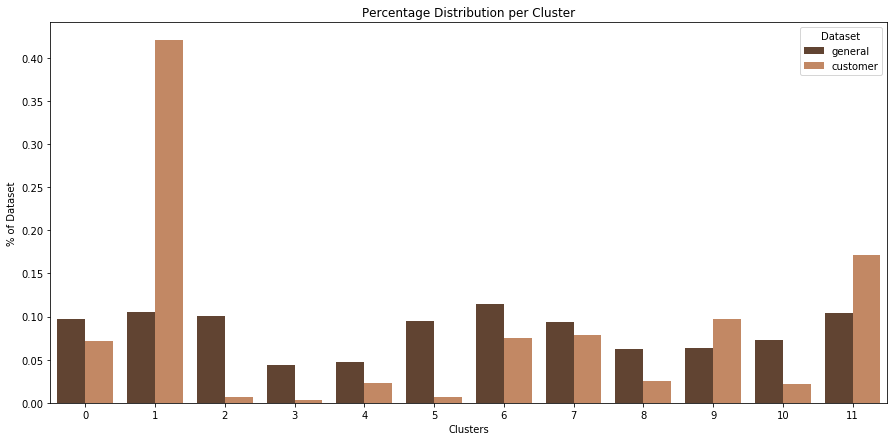

In [31]:
# plot bar chart with labels_concat dataframe
plt.figure(figsize=(15, 7))
sns.barplot(x="Label", y="Mean", hue="Dataset", data=labels_concat, palette="copper")
plt.xlabel("Clusters")
plt.ylabel("% of Dataset")
plt.title("Percentage Distribution per Cluster")

In [32]:
# underrepresented centroid
centroid_2 = pipeline["scaler"].inverse_transform(pca_200.inverse_transform(model_12.cluster_centers_[2]))

In [39]:
# recover datapoints from centroid
underrepresented_cluster = pd.DataFrame(data = centroid_2, index = customer_df.columns)
underrepresented_cluster.to_csv("./data/underrepresented2.csv")
underrepresented_cluster.head(20)

,0
LNR,715905.590948
AKT_DAT_KL,6.204415
ALTER_HH,17.659728
ALTERSKATEGORIE_FEIN,17.601057
ANZ_HAUSHALTE_AKTIV,4.835223
ANZ_HH_TITEL,0.014805
ANZ_KINDER,0.118880
ANZ_PERSONEN,1.400270
ANZ_STATISTISCHE_HAUSHALTE,4.334867
ANZ_TITEL,0.000460


In [40]:
# overrepresented centroid
centroid_1 = pipeline["scaler"].inverse_transform(pca_200.inverse_transform(model_12.cluster_centers_[1]))

In [41]:
# recover datapoints from centroid
overrepresented_cluster = pd.Series(data = centroid_1, index = customer_df.columns)
overrepresented_cluster.to_csv("./data/overrepresented1.csv")
overrepresented_cluster.head(20)

LNR                           686985.701143
AKT_DAT_KL                         2.242048
ALTER_HH                          13.398269
ALTERSKATEGORIE_FEIN              10.472918
ANZ_HAUSHALTE_AKTIV                1.622112
ANZ_HH_TITEL                       0.013806
ANZ_KINDER                         0.053195
ANZ_PERSONEN                       2.206484
ANZ_STATISTISCHE_HAUSHALTE         1.606485
ANZ_TITEL                          0.008797
BALLRAUM                           4.043520
CAMEO_INTL_2015                    2.068753
CJT_GESAMTTYP                      3.049295
CJT_KATALOGNUTZER                  3.387897
CJT_TYP_1                          2.110457
CJT_TYP_2                          1.822080
CJT_TYP_3                          4.240032
CJT_TYP_4                          4.274003
CJT_TYP_5                          4.355820
CJT_TYP_6                          4.300054
dtype: float64